# Performing the Higgs -> WW-> l leptons search 

##  Cut-based analysis

Focus on discriminating Higgs signal from irreducible SM WW production.

Final state is 2 leptons + missing tranverse momentum.

No peak structure available as for H->ZZ->4l






<a id='contents'></a>

<a id='running'></a>

# Installation of packages not available by default on colab


In [ ]:
import sys
# update the pip package installer
#%pip install --upgrade --user pip
# install required packages
#%pip install --upgrade --user uproot awkward vector numpy matplotlib

!pip install uproot
!pip install vector
!pip install awkward
!pip install hist

## Import packages used in the analysis

We're going to be using a number of tools to help us:
* uproot: lets us read .root files typically used in particle physics into data formats used in python
* awkward: lets us store data as awkward arrays, a format that generalizes numpy to nested data with possibly variable length lists
* vector: to allow vectorized 4-momentum calculations
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations

In [ ]:
import uproot # for reading .root files
import awkward as ak # to represent nested data in columnar format
import vector # for 4-momentum calculations
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt
import pandas as pd


## Data fraction, file path

General definitions of fraction of data used, where to access the input files

In [ ]:
#lumi = 0.5 # fb-1 # data_A only
#lumi = 1.9 # fb-1 # data_B only
#lumi = 2.9 # fb-1 # data_C only
#lumi = 4.7 # fb-1 # data_D only
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D
fraction = 600000 # reduce this is if you want the code to run quicker

<a id='fraction'></a>

In [ ]:
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/2lep/" # web address

Units, as stored in the data files.<br /> 
The quantities in the ATLAS ntuple are unfortunately stored in MeV.<br />
Since the natural unit for LHC analysis is GeV, we define conversion factors

In [ ]:
MeV = 0.001
GeV = 1.0
mz = 91.12

Define different classes of ntuples to access as a dictionary called "samples".<br />
One has four types of ntuples:<br />
<ul>
<li>Data: the real data collected by ATLAS at the LHC
<li>Reducible backgrounds: 
<li>Irreducible backgrounds
<li>Signal
</ul>
The names in the list must correspond to the names of a sample defined in infofile.py

In [ ]:
samples = {
#  'data': {
#    'list' : ['data_A','data_B','data_C','data_D'],
#  },
#  'background' : { # ttbar
#     'list' : ['ttbar_lep'],
#     'color' : "#6b59d3" # purple
#  },
  'background' : { # WW
     'list' : ['llvv'],
     'color' : "#ff0000" # red
  },
  'signal' : { # H -> WW -> llvv
     'list' : ['ggH125_WW2lep'],
     'color' : "#00cdff" # light blue
  },
}

In [ ]:
import os.path
if os.path.isfile('infofile.py')==False:
  !wget https://raw.githubusercontent.com/atlas-outreach-data-tools/notebooks-collection-opendata/master/13-TeV-examples/uproot_python/infofile.py    
import infofile    
#!head -n 12 infofile.py

In [ ]:
def get_xsec_weight(sample):
  info = infofile.infos[sample] # open infofile
  xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
  return xsec_weight # return cross-section weight

def calc_weight(xsec_weight, events):
    return (
        xsec_weight
        * events.mcWeight
        * events.scaleFactor_PILEUP
        * events.scaleFactor_ELE
        * events.scaleFactor_MUON
        * events.scaleFactor_LepTRIGGER
    )

In [ ]:
def get_data_from_files():

  data = {} # define empty dictionary to hold dataframes
  for s in samples: # loop over samples
    print('Processing '+s+' samples') # print which sample
    frames = [] # define empty list to hold data
    for val in samples[s]['list']: # loop over each file
      if s == 'data': prefix = "Data/" # Data prefix
      else: # MC prefix
        prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
      fileString = tuple_path+prefix+val+".2lep.root" # file name to open
      temp = read_file(fileString,val) # call the function read_file defined below
      frames.append(temp) # append dataframe returned from read_file to list of dataframes
    data[s] = pd.concat(frames) # dictionary entry is concatenated dataframes

  return data # return dictionary of dataframes

Define function to calculate 4-lepton invariant mass.<br />
It accesses the dataframe where the particle data are stored as scalar components, and creates an array of 4-vectors 

In [ ]:
def calc_kine(dff):
    pl1=vector.array({"pt":dff["ptl1"], "phi":dff["phil1"],
       "eta":dff["etal1"], "e":dff["el1"]})
    pl2=vector.array({"pt":dff["ptl2"], "phi":dff["phil2"],
       "eta":dff["etal2"], "e":dff["el2"]})
    etmv=vector.array({"pt":dff["met_et"], "phi":dff["met_phi"]})
    etm=dff["met_et"]
    pll=pl1+pl2
    dphill=pl1.deltaphi(pl2)
    dphillm=pll.deltaphi(etmv)
    mll=pll.M
    ptll=pll.pt
    return mll,dphill,ptll,dphillm

In [ ]:
def calc_dphil1m(dff):
    pl=vector.array({"pt":dff["ptl1"], "phi":dff["phil1"],
       "eta":dff["etal1"], "e":dff["el1"]})
    em=vector.array({"pt":dff["met_et"], "phi":dff["met_phi"]})
    return pl.deltaphi(em)
def calc_dphil2m(dff):
    pl=vector.array({"pt":dff["ptl2"], "phi":dff["phil2"],
       "eta":dff["etal2"], "e":dff["el2"]})
    em=vector.array({"pt":dff["met_et"], "phi":dff["met_phi"]})
    return pl.deltaphi(em)

Simple template for a selection function acting on the dataframe, it creates a boolean

In [ ]:
def cut_iso(df):
   isol1=(df["ptcl1"]/df["ptl1"]<0.2) & (df["etcl1"]/df["ptl1"]<0.2)
   isol2=(df["ptcl2"]/df["ptl2"]<0.2) & (df["etcl2"]/df["ptl2"]<0.2)
   return isol1 & isol2
def cut_ossf(df):
   ltc1=df["chl1"]*df["typl1"]
   ltc2=df["chl2"]*df["typl2"]
   return (ltc1+ltc2!=0) & ((df["chl1"]+df["chl2"])>0) 
def cut_tight(df):
   return (df["tightl1"]==1) & (df["tightl2"]==1)

Define function to get data from files.

The datasets used in this notebook have already been filtered to include at least 4 leptons per event

In [ ]:
def read_file(path, sample):
  with uproot.open( path + ":mini") as tree:
    numevents = tree.num_entries # number of events
    stopev=numevents*fraction
    if fraction>1:
      stopev=fraction
    if 'data' not in sample: xsec_weight = get_xsec_weight(sample) # get cross-section weight
# variables to extract from ntuple
    lepvar=["lep_pt", "lep_eta", "lep_phi","lep_E",
          "lep_charge","lep_type",
          "lep_ptcone30","lep_etcone20", "lep_isTightID"]
    scalvar=["met_et","met_phi","jet_n"]
    weivar=["mcWeight","scaleFactor_PILEUP",
            "scaleFactor_ELE","scaleFactor_MUON",
            "scaleFactor_LepTRIGGER"] # variables to calculate Monte Carlo weight
    tupvar=weivar+lepvar+scalvar
# read tree into awkward array with uproot
    print("num",numevents, stopev)
    lep_momentum = tree.arrays(tupvar,entry_stop=stopev,library="ak")
# define the names of the variables to go into dataframe
    colnam=["ptl1","etal1","phil1","el1","chl1","typl1","ptcl1","etcl1","tightl1",
          "ptl2","etal2","phil2","el2","chl2","typl2","ptcl2","etcl2","tightl2"]
# create numpy vector assuming that lep_ arrays have 4 components
    for i in range(0,2):
      for j in range(0,len(lepvar)):
        if i==0 and j==0:
          ptlep=ak.to_numpy(lep_momentum[lepvar[j]][:,i])
        else:
          ptlep=np.vstack([ptlep,ak.to_numpy(lep_momentum[lepvar[j]][:,i])])
# end up with numpy 2d vector with n_var rows and n_event columns
# to transpose, as in pandas 'features' are columns and 'observations' rows
    ptlep=ptlep.transpose()
# create dataframe 
    df = pd.DataFrame(ptlep)
# add names of columns
    df.columns=colnam 
# add scalar variables
    for i in range(0, len(scalvar)):
      df[scalvar[i]]=lep_momentum[scalvar[i]]
#   calculate dphi rotation variables
    df["dphil1m"]=calc_dphil1m(df)
    df["dphil2m"]=calc_dphil2m(df)
#   calculate lepton-lepton variables
    mll,dphill,ptll,dphillm=calc_kine(df)
    df["dphill"]=np.abs(dphill)
    df["dphillm"]=np.abs(dphillm)
    df["mll"]=mll
    df["ptll"]=ptll
# add MC weights and signal/background labelling
    if 'data' not in sample: # only do this for Monte Carlo simulation files
# multiply all Monte Carlo weights and scale factors together to give total weight
      df["totalWeight"] = calc_weight(xsec_weight, lep_momentum)*numevents/stopev
      if  'H125' in sample:
        df["SIG"]=np.ones(df.shape[0])
      else:
        df["SIG"]=np.zeros(df.shape[0])
    print("dataframe content " ,df.shape)
    return df

This is where the processing happens

In [ ]:
start = time.time() # time at start of whole processing
df = get_data_from_files() #process all files
print(df.keys())
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

## Apply preselections or add secondary variables if desired to separate datafranes

Define routine which loops over all the samples in the dictionary of dataframes and applies
selections on them. <br />
It would be simpler to apply the cuts when reading the files, but in this way you can play with 
the selections without the need of reloading the files every time<br />
One can also create dataframes with different selection levels and compare them

In [ ]:
def add_columns(df):

  data = {} # define empty dictionary to hold dataframes
  for s in samples: # loop over samples
    print('Add columns '+s+' samples') # print which sample
    print('before', df[s].shape) 
    adddf=df[s] 
    data[s]=adddf

  return data # return dictionary of dataframes

In [ ]:
def apply_selections(df):

  data = {} # define empty dictionary to hold dataframes
  for s in samples: # loop over samples
    print('Apply selections on '+s+' samples') # print which sample
    print('before', df[s].shape) 
    seldf=df[s]
    seldf=seldf.query("ptl1>20000")
    print('after',seldf.shape)
    data[s]=seldf
#    data[s] = pd.concat(frames) # dictionary entry is concatenated dataframes

  return data # return dictionary of dataframes

In [ ]:
# Calculate events for available samples in dataframe dictionary normalised
# to available statistics
def calc_events(df):
  stat = {} # define empty dictionary to hold stat
  for s in samples: # loop over samples
    if s not in ['data']: 
      print('Calculate events on '+s+' samples') # print which sample
      stat[s]=(df[s]['totalWeight']).sum()
    if s in ['data']:
      stat[s]=df[s].shape[0]
  return stat # return dictionary of statistics

## Look at signal and background statistics after reading data

In [ ]:
finstat=calc_events(df)
nsig=finstat['signal']
nbg=finstat['background']
print(nsig,nbg)

## Apply preselections and check  numbers of events normalised to statistics

In [ ]:
dfs=apply_selections(df)

In [ ]:
finstat1=calc_events(dfs)
nsig1=finstat1['signal']
nbg1=finstat1['background']
print(nsig1,nbg1)

## Calculation of significance

In [ ]:
from math import sqrt, log
def calc_sig(nsig, nbg, nbExpEr):
    nbObs=nsig+nbg
    nbExp=nbg
    if nbExp>0 and nbExpEr>0:
      factor1 = nbObs*log( (nbObs*(nbExp+nbExpEr**2))/(nbExp**2+nbObs*nbExpEr**2) )
      factor2 = (nbExp**2/nbExpEr**2)*log( 1 + (nbExpEr**2*(nbObs-nbExp))/(nbExp*(nbExp+nbExpEr**2)) )
      signi  = sqrt(2*(factor1 - factor2))
    if nbExp>0 and nbExpEr==0:
      signi=sqrt(2*((nsig+nbg)*log(1+nsig/nbg)-nsig))
    if nbExp==0 and nbExpEr==0:
      signi=sqrt(nsig)
    if nbExp==0 and nbExpEr>0:
      signi=nsig/sqrt(nbExpEr)
    return signi

In [ ]:
print("significance is ",calc_sig(nsig1,nbg1,0.))

## Join samples into a dataframe including only variables to be used for analysis

Cut analysis can be directly performed using the dataframes created below, since we later want to go to ML, lets create already a dataframe only with the ntuples which will be used for cuts, with both signal and background in a single file, with the relative lebelling in the variable SIG.

In [ ]:
tfea = ['SIG','ptl1','ptl2','dphil1m','dphil2m','etal1','etal2','met_et','mll','ptll','dphill','dphillm','totalWeight'] # list of features for discriminant analysis
# concatenate all samples
df_all=pd.concat(df[key][tfea] for key in df)
for key in df:
   print(key,df[key].shape[0])
df_all.columns=tfea
#print(df_all.keys)
# randomize it
df_all=df_all.sample(frac=1)
# kludge, put reasonable upper limit on unbounded variables to allow automatic plotting
# in a reasobnable range
df_all=df_all.query("ptl1<500000 & ptl2<250000 & met_et<500000 & mll<500000 & ptll<500000")
print("df_all ", df_all.shape)
split=1000000
df_val=df_all[split:]
print("df_val ", df_val.shape)
df_all=df_all[:split]
print("df_all ", df_all.shape)

# Go for cut-based analysis

First step is visual inspection of  all variables in dataframe to find the ones with best discriminating power.
We will use some standard tools for the inspection

Use seaborn library https://seaborn.pydata.orgto get a synoptic view of all variables

First one-dimensional

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Look at variables: first basic kinematics
nrow = int(len(tfea)/3)
print(nrow)
print 
if(len(tfea)%3>0):
  nrow=nrow+1
if nrow==0:
  nrow=1;
fig, axes = plt.subplots(nrow,3  , figsize=(14, 3.5*nrow))
for ii in range (0, len(tfea)):
  idf=ii
  i1=int(ii/3)
  i2=ii%3
  sns.histplot( df_all, ax=axes[i1,i2], x=tfea[idf], hue="SIG",element="step")
plt.show()

Then bidimensional for promising variables

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

dfsmall=df_all.head(5000) 
g = sns.pairplot(dfsmall, vars=["met_et", "mll","dphill"], hue="SIG",height=5)
#g = sns.PairGrid(df1, vars=["MET_val", "MET_rel","axial_MET"], hue="SIG",height=5)
#g.map_diag(sns.histplot)
#g.map_offdiag(sns.scatterplot, s=20)
g.add_legend()

## Free Plotting

Set simple wrapper for plotting histograms with matplotlib

In [ ]:
# in input:  df=dataframe var=variable in dataframe, 
# scale=scale factor on value of variable (e.g. for scaling between MeV and GeV)
# nbin,xlow,xhigh: limits of histogram
# norm: choose whether you plot acutal number of events in bin or fraction of events 
#       in each bin with respect to total
# labx, laby labels of x and y axis of histogram 
# title: title of hisotgram
# leg: legenda for content, useful if you superimpose two hists
def hist1d(df, var, scale, nbin, xlow, xhig, norm, labx, laby, title, leg):
  bins = np.linspace(xlow,xhig,nbin)
  plt.hist(df[var]*scale, bins, alpha=0.5, density=norm, label=leg)
  plt.xlabel(labx)
  plt.ylabel(laby)
  plt.legend(loc='best')
# 2d, same definition of inputs as above
def hist2d(df,var1,var2,scalex,scaley,nbinx,xlow,xhig,nbiny,ylow,yhig,labx,laby,title):
  binx = np.linspace(xlow,xhig,nbinx)
  biny = np.linspace(ylow,yhig,nbiny)
  plt.hist2d(df[var1]*scalex, df[var2]*scaley, bins=[binx, biny], density=False, cmin=0.5)
  plt.xlabel(labx)
  plt.ylabel(laby)

In [ ]:
hist1d(df_all.query("SIG==0"),"mll",MeV,100,0.,500.,False,'mll [GeV]','Number of events','','Background')
hist1d(df_all.query("SIG==1"),"mll",MeV,100,0.,500.,False,'mll [GeV]','Number of events','Unscaled','Signal')
plt.show()
hist2d(df_all.query("SIG==0"),"ptl1","etal1",MeV,1,100,0.,200.,100,-3.,3.,'pt(lep1) [GeV]','pt(lep2) [GeV]','')
plt.show()

In [ ]:
def plot_varsel(df, sel1, sel2, var, blow, bhigh, nbin):
  df_pass = df.query(sel1)
  df_nopass = df.query(sel2)
  bins = np.linspace(blow, bhigh, nbin)
  plt.hist(df_pass[var], bins, alpha=0.5, density=True, label=sel1)
  plt.hist(df_nopass[var], bins, alpha=0.5, density=True, label=sel2)
  plt.legend(loc='best')
  plt.xlabel(var)
  plt.ylabel('normalised events')
  plt.show()

In [ ]:
string="mll<55000"
df_all_s=df_all.query(string)

In [ ]:
numsig=df_all_s.query("SIG==1")["totalWeight"].sum()
numbg=df_all_s.query("SIG==0")["totalWeight"].sum()
print('after cuts; signal:',numsig,' background:',numbg)

In [ ]:
print("significance is:",calc_sig(numsig, numbg, 0.001*numbg))

In [ ]:
hist1d(df_all_s.query("SIG==0"),"ptl1",MeV,100,0.,200.,True,'mll','Number of events','','Background')
hist1d(df_all_s.query("SIG==1"),"ptl1",MeV,100,0.,200.,True,'mll','Number of events','','Signal')
plt.show()

## Exercises



* Play around with cuts trying to achieve the best possible significance when fighting with WW background
    * Implement the mT variable defined as 
    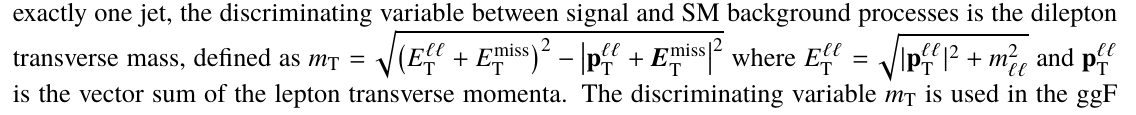
    in the ATLAS WW paper https://www.sciencedirect.com/science/article/pii/S0370269318309936?via%3Dihub
    and verify the impact on the analysis
* Replace WW background with ttbar background and try same exercise.<br /> 
    Hints: 
     * number of jets become important.
     * build the variable corresponding to the modulus of the vector sum of the transverse momenta  of the two lepton and Etmiss.<br />Add it to the dataframe and verify whether it is a good discriminant variable
* Redo exercise with both WW and ttbar on